## Part 1 Time Series Analysis

In [1]:
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

### Stationarity
Differences need to be applied if data is not stationary.

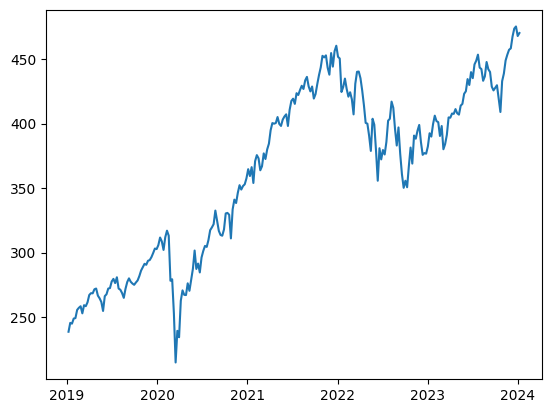

In [2]:
msft = yf.Ticker("SPY")

# get all stock info
# msft.info

# get historical market data
df = msft.history(period='5y', interval='1wk')
df = df[['Close']]
plt.plot(df)

In [3]:
df.head(10)

,Close
Date,
2019-01-07 00:00:00-05:00,238.667282
2019-01-14 00:00:00-05:00,245.560501
2019-01-21 00:00:00-05:00,244.933868
2019-01-28 00:00:00-05:00,248.878189
2019-02-04 00:00:00-05:00,249.256012
2019-02-11 00:00:00-05:00,255.614822
2019-02-18 00:00:00-05:00,257.246002
2019-02-25 00:00:00-05:00,258.425659
2019-03-04 00:00:00-05:00,252.933029


The adfuller test can help us do hypothesis testing on the stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df):
    result=adfuller(df)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('Ho: Data is non-stationary')
    print('H1: Data is stationary')
    print()
    if result[1] <= 0.05:
        print("p < 0.05, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("p > 0.05, weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df)

ADF Test Statistic : -1.305351379998848
p-value : 0.6267205083498864
#Lags Used : 0
Number of Observations : 261
Ho: Data is non-stationary
H1: Data is stationary

p > 0.05, weak evidence against null hypothesis,indicating it is non-stationary 


Look at the differences, taking the first order of difference will give us stationarity

In [5]:
first_order_difference = df - df.shift(1)
adfuller_test(first_order_difference.dropna())

ADF Test Statistic : -17.05742608255993
p-value : 7.990514296568729e-30
#Lags Used : 0
Number of Observations : 260
Ho: Data is non-stationary
H1: Data is stationary

p < 0.05, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


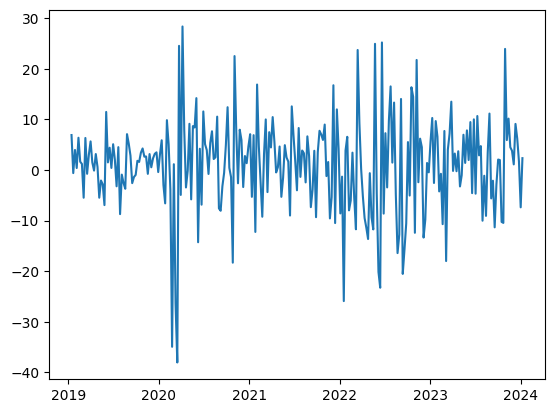

In [6]:
plt.plot(first_order_difference.index, first_order_difference.values)

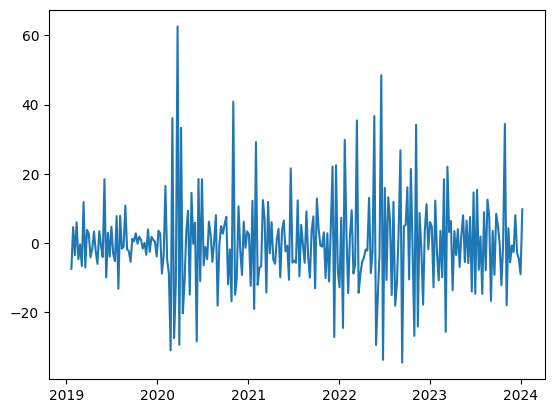

In [7]:
second_order_difference = first_order_difference - first_order_difference.shift(1)
plt.plot(second_order_difference.index, second_order_difference.values)

### Autocorrelation
We should plot autocorrelation based on the differences that we plan to use.

Note that this is on the actual values, it will only be useful if we are using d = 0

The autocorrelation plot shows the correlation between $y_t$ and $y_{t-k}$ with all the influencing variables removed. Here is an explanation from stack exchange
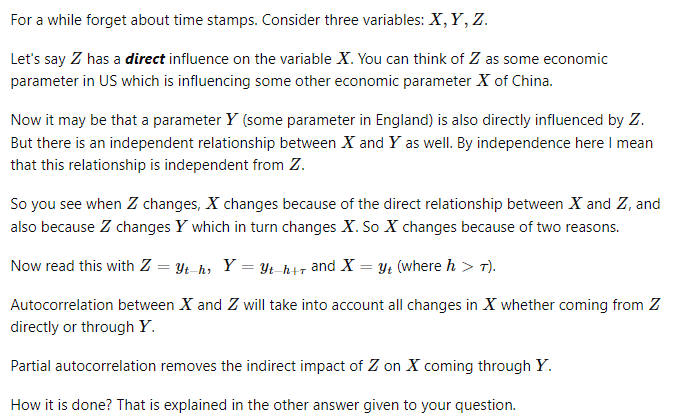



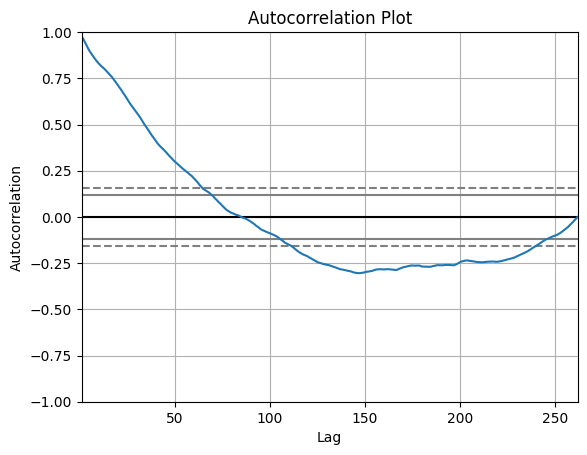

In [8]:
from pandas.plotting import autocorrelation_plot

ax = autocorrelation_plot(df)
ax.set_title('Autocorrelation Plot')
# ax.set_xlim(right=365)
# ax.set_ylim(bottom=0.5)
plt.show()

We can also use statsmodels' library

This time use the first order of difference, removed lag of 0 (the same value itself will have correlation of 1)

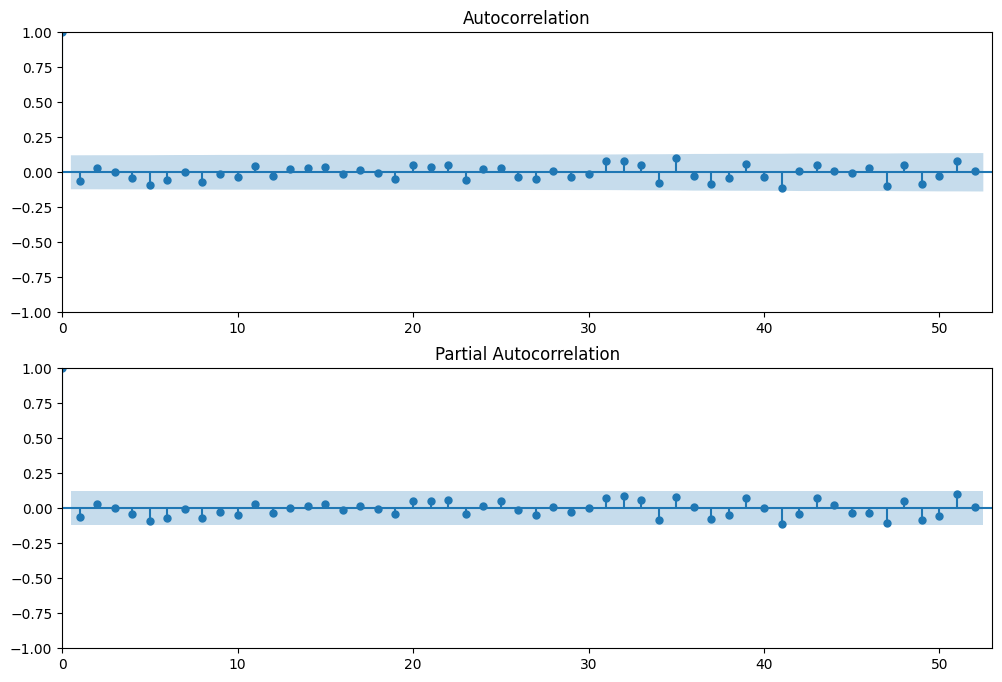

In [9]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
lags = 52

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(left=0, right = lags+1)
fig = sm.graphics.tsa.plot_acf(first_order_difference.dropna(),lags=lags,ax=ax1)

ax2 = fig.add_subplot(212)
ax2.set_xlim(left=0, right = lags+1)
fig = sm.graphics.tsa.plot_pacf(first_order_difference.dropna(),lags=lags,ax=ax2)

### pdq of ARIMA
p: The lag order, representing the number of lag observations incorporated in the model.

d: Degree of differencing, denoting the number of times raw observations undergo differencing.

q: Order of moving average, indicating the size of the moving average window.


In [10]:
# We need the index to be periods for ARIMA
time_series = df.copy()
time_series.index = time_series.index.to_period('W') 
# Doing this conversion on daily interval will mess up our dates because the original data did not include weekend dates

C:\Users\stell\AppData\Local\Temp\ipykernel_8712\549776980.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  time_series.index = time_series.index.to_period('W')


In [11]:
p = 1
d = 1 # From the graph above, data is not stationary, we will apply difference of 1
q = 1 

model = ARIMA(time_series, order=(p, d, q))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  262
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.497
Date:                Mon, 08 Jan 2024   AIC                           1908.993
Time:                        23:37:11   BIC                           1919.687
Sample:                    01-13-2019   HQIC                          1913.292
                         - 01-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4375      0.653     -0.670      0.503      -1.718       0.843
ma.L1          0.3852      0.669      0.576      0.565      -0.926       1.697
sigma2        85.9112      5.320     16.149      0.0

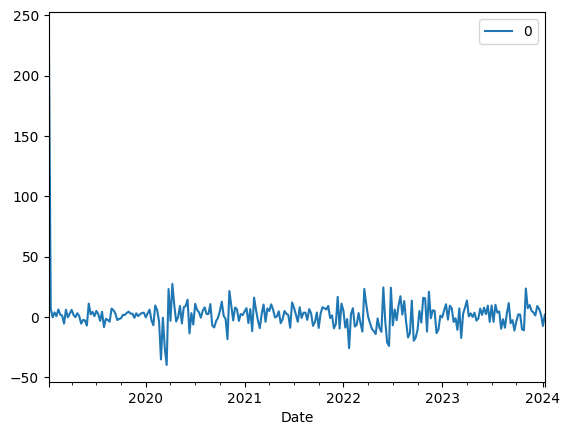

In [12]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

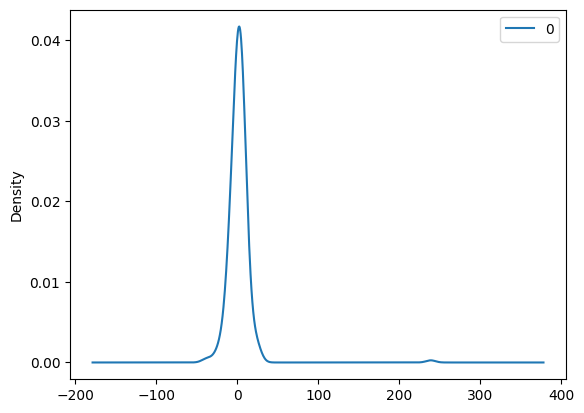

                0
count  262.000000
mean     1.827495
std     17.343612
min    -39.713880
25%     -3.819683
50%      1.961202
75%      6.183066
max    238.667282


In [13]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [14]:
evaluation = time_series.copy()
evaluation['fitted_values'] = model_fit.fittedvalues
# in_sample_predictions = model_fit.predict(start=1, end = 262, dynamic=False) # This is similar to fittedvalues
evaluation['residuals'] = model_fit.resid[1:]
evaluation

,Close,fitted_values,residuals
Date,,,
2019-01-07/2019-01-13,238.667282,0.000000,NaN
2019-01-14/2019-01-20,245.560501,238.666179,6.894322
2019-01-21/2019-01-27,244.933868,245.191164,-0.257296
2019-01-28/2019-02-03,248.878189,245.108981,3.769208
2019-02-04/2019-02-10,249.256012,248.604181,0.651831
...,...,...,...
2023-12-11/2023-12-17,467.434814,458.361011,9.073803
2023-12-18/2023-12-24,473.649994,466.951439,6.698555
2023-12-25/2023-12-31,475.309998,473.510880,1.799118


In [15]:
import numpy as np

def MSE(y, yhat, p):
    '''
    Calculate MSE, ignores the lag periods at the start
    '''
    y = y[p:]
    yhat = yhat[p:]
    return round(1/len(y)*(np.sum(y-yhat))**2, 3)

mse = MSE(evaluation['Close'], evaluation['fitted_values'], p)
print(f'Mean squared error for fitted values : {mse}')

Mean squared error for fitted values : 220.941


In [16]:
len(model_fit.fittedvalues)

262

Notice that ARIMA does not incorporate Seasonality, it is unable forecast well especially on stock data which high seasonality

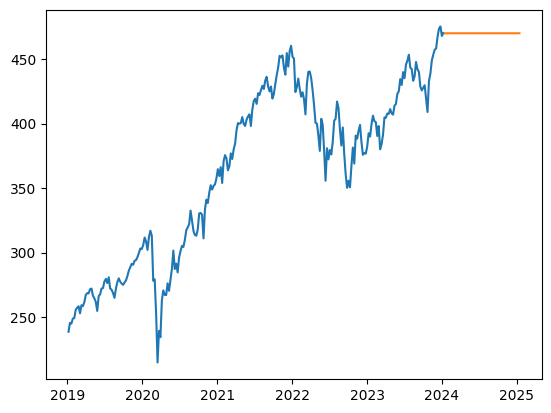

In [17]:
out_of_sample_predictions = model_fit.predict(start=len(df), end = len(df)+52, dynamic=False)
# Use .to_timestamp() to convert period back into timestamp for plotting
plt.plot(time_series.to_timestamp())
plt.plot(out_of_sample_predictions.to_timestamp())

## SARIMA - includes Seasonal Elements<br>
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.<br>
D: Seasonal difference order.<br>
Q: Seasonal moving average order.<br>
m: The number of time steps for a single seasonal period.

f:\python_stuff\financial_analysis_forecasting\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


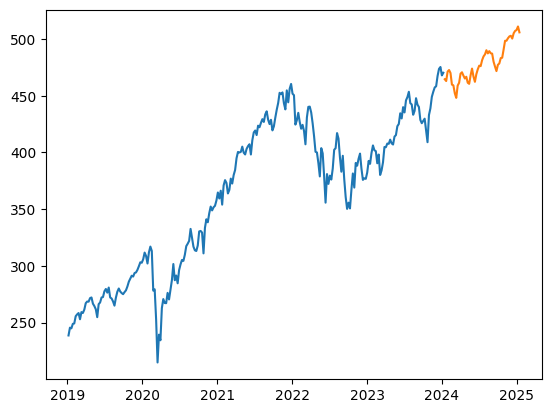

In [18]:
P = 1
D = 1
Q = 1
m = 52


# model = sm.tsa.statespace.SARIMAX(time_series, order=(p, d, q),seasonal_order=(P,D,Q,m))
model = ARIMA(time_series, order=(p, d, q),seasonal_order=(P,D,Q,m)) 

model_seasonality=model.fit()
out_of_sample_predictions = model_seasonality.predict(start=len(df), end = len(df)+52, dynamic=False)
# Use .to_timestamp() to convert period back into timestamp for plotting
plt.plot(time_series.to_timestamp())
plt.plot(out_of_sample_predictions.to_timestamp())

In [19]:
print(model_seasonality.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            Close   No. Observations:                  262
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -797.381
Date:                          Mon, 08 Jan 2024   AIC                           1604.762
Time:                                  23:37:52   BIC                           1621.474
Sample:                              01-13-2019   HQIC                          1611.519
                                   - 01-14-2024                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3725      0.375     -0.995      0.320      -1.107       0.362
ma.L1          0.2360      0.386      0.611      0.

Lower MSE can be achieved with seasonality incorporated - AIC from 1700 for ARIMA to 1600 for SARIMA

In [20]:
mse = MSE(time_series.squeeze(), model_seasonality.fittedvalues, p)
print(f'Mean squared error for fitted values : {mse}')

Mean squared error for fitted values : 83.868
